<a href="https://colab.research.google.com/github/NamanVerma27/India_AQI_Analysis-Project/blob/main/AQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when, round, expr

In [33]:
def create_spark_session():
    """
    Create a Spark session for data processing
    """
    return SparkSession.builder \
        .appName("IndianAirQualityAnalysis") \
        .getOrCreate()

In [34]:
def load_air_quality_data(spark, file_path):
    """
    Load air quality dataset with proper schema
    """
    # Read the CSV file
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Convert Date column to date type using expr()
    df = df.withColumn("Date", expr("to_date(Date)"))

    return df

In [35]:
def initial_data_exploration(df):
    """
    Perform initial data exploration and basic cleaning
    """
    # Print basic information about the dataset
    print("Total number of records:", df.count())
    print("\nUnique Cities:", df.select("City").distinct().count())

    # Date range using expr()
    print("\nDate Range:")
    df.select(
        expr("min(Date) as min_date"),
        expr("max(Date) as max_date")
    ).show()

    # Basic column statistics
    print("\nColumn Statistics:")
    columns_to_analyze = ["PM2.5", "PM10", "NO2", "AQI"]
    for column in columns_to_analyze:
        print(f"\n{column} Column Statistics:")
        # Enclose column name in backticks to handle special characters
        df.select(
            expr(f"avg(`{column}`) as mean"),
            expr(f"stddev(`{column}`) as std"),
            expr(f"min(`{column}`) as min"),
            expr(f"max(`{column}`) as max")
        ).show()

    return df

In [36]:
def main():
    # Create Spark Session
    spark = create_spark_session()

    # Load Data - replace with your actual file path
    file_path = "city_day.csv"
    air_quality_df = load_air_quality_data(spark, file_path)

    # Perform Initial Exploration
    initial_data_exploration(air_quality_df)

if __name__ == "__main__":
    main()

Total number of records: 29531

Unique Cities: 26

Date Range:
+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2015-01-01|2020-07-01|
+----------+----------+


Column Statistics:

PM2.5 Column Statistics:
+-----------------+-----------------+----+------+
|             mean|              std| min|   max|
+-----------------+-----------------+----+------+
|67.45057794890272|64.66144945715128|0.04|949.99|
+-----------------+-----------------+----+------+


PM10 Column Statistics:
+------------------+-----------------+----+------+
|              mean|              std| min|   max|
+------------------+-----------------+----+------+
|118.12710293078102|90.60510971779476|0.01|1000.0|
+------------------+-----------------+----+------+


NO2 Column Statistics:
+------------------+------------------+----+------+
|              mean|               std| min|   max|
+------------------+------------------+----+------+
|28.560659061126763|24.474745795589442|0.01|362.21|
+-----

In [37]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, round, expr, avg, stddev, max as spark_max

def clean_air_quality_data(df):
    """
    Clean and preprocess air quality data

    Args:
        df (DataFrame): Input air quality DataFrame

    Returns:
        DataFrame: Cleaned and processed DataFrame
    """
    # Handle missing values - Use backticks to escape special characters
    cleaned_df = df.fillna({
        "`PM2.5`": 0,  # Changed "PM2.5" to "`PM2.5`"
        "`PM10`": 0,  # Changed "PM10" to "`PM10`"
        "NO2": 0,
        "AQI": 0
    })

    # Create pollution level categories
    # Changed the when condition to check if PM2.5 is less than or equal to 30 for "Good" category
    cleaned_df = cleaned_df.withColumn("PM2.5_Category",
        when(col("`PM2.5`") <= 30, "Good")
        .when((col("`PM2.5`") > 30) & (col("`PM2.5`") <= 60), "Moderate")
        .when((col("`PM2.5`") > 60) & (col("`PM2.5`") <= 90), "Unhealthy for Sensitive Groups")
        .otherwise("Unhealthy")
    )

    # Round numeric columns  - Use backticks to escape special characters
    numeric_columns = ["`PM2.5`", "`PM10`", "NO2", "AQI"] # Changed "PM2.5" to "`PM2.5`" and "PM10" to "`PM10`"
    for column in numeric_columns:
        cleaned_df = cleaned_df.withColumn(column, round(col(column), 2))

    return cleaned_df

In [38]:
def analyze_city_pollution(df):
    """
    Analyze pollution levels by city

    Args:
        df (DataFrame): Cleaned air quality DataFrame

    Returns:
        DataFrame: City-wise pollution analysis
    """
    city_pollution_analysis = df.groupBy("City").agg(
        round(avg("`PM2.5`"), 2).alias("Avg_PM2.5"),  # Changed "PM2.5" to "`PM2.5`"
        round(stddev("`PM2.5`"), 2).alias("Std_PM2.5"),  # Changed "PM2.5" to "`PM2.5`"
        round(spark_max("`PM2.5`"), 2).alias("Max_PM2.5"),  # Changed "PM2.5" to "`PM2.5`"
        round(avg("AQI"), 2).alias("Avg_AQI"),
        expr("count(*) as Total_Measurements")
    ).orderBy("Avg_AQI", ascending=False)

    return city_pollution_analysis

In [39]:
def main():
    # Create Spark Session
    spark = create_spark_session()

    # Load Data
    file_path = "city_day.csv"
    air_quality_df = load_air_quality_data(spark, file_path)

    # Clean Data
    cleaned_df = clean_air_quality_data(air_quality_df)

    # Analyze City-wise Pollution
    city_pollution = analyze_city_pollution(cleaned_df)

    # Show results
    city_pollution.show(10)

    # Optional: Save results
    city_pollution.write.csv("city_pollution_analysis.csv", header=True, mode="overwrite")

if __name__ == "__main__":
    main()

+---------+---------+---------+---------+-------+------------------+
|     City|Avg_PM2.5|Std_PM2.5|Max_PM2.5|Avg_AQI|Total_Measurements|
+---------+---------+---------+---------+-------+------------------+
|Ahmedabad|    46.64|    45.41|   381.69| 300.22|              2009|
|    Delhi|   117.08|    82.95|   685.36|  258.2|              2009|
|  Lucknow|   104.14|    81.35|   742.67| 205.39|              2009|
| Gurugram|   106.36|   100.27|   949.99| 194.82|              1679|
|    Patna|   102.16|    97.55|    645.5| 189.07|              1858|
| Guwahati|    63.56|    61.64|   916.67| 138.16|               502|
|   Jaipur|    53.91|     27.0|   311.35| 131.28|              1114|
|  Talcher|    49.19|    51.13|   354.44| 130.46|               925|
|  Kolkata|    60.01|    58.64|   304.74| 130.21|               814|
|   Bhopal|     48.5|    31.19|   136.42| 127.77|               289|
+---------+---------+---------+---------+-------+------------------+
only showing top 10 rows



In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, avg, round, col
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, dense_rank
from pyspark.sql.functions import to_date  # Import to_date function
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [61]:
# Helper function to create Spark session
def create_spark_session():
    spark = SparkSession.builder \
        .appName("Air Quality Analysis") \
        .getOrCreate()
    return spark

# Helper function to load data
def load_air_quality_data(spark, file_path):
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    return df

# Data cleaning function
def clean_air_quality_data(df):
    df = df.fillna({'`PM2.5`': df.agg({'`PM2.5`': 'avg'}).collect()[0][0],
                    'AQI': df.agg({'AQI': 'avg'}).collect()[0][0]})
    df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
    return df

# Analyze yearly trends function
def analyze_yearly_trends(df):
    yearly_trends = df.withColumn("Year", year("Date")).groupBy("Year", "City").agg(
        round(avg("`PM2.5`"), 2).alias("Avg_PM2.5"),
        round(avg("AQI"), 2).alias("Avg_AQI")
    ).orderBy("Year", "City")
    print("Yearly Pollution Trends:")
    yearly_trends.show()
    return yearly_trends

# Analyze seasonal (monthly) patterns
def analyze_seasonal_patterns(df):
    monthly_patterns = df.withColumn("Month", month("Date")).groupBy("Month").agg(
        round(avg("`PM2.5`"), 2).alias("Avg_PM2.5"),
        round(avg("AQI"), 2).alias("Avg_AQI")
    ).orderBy("Month")
    print("Monthly Pollution Patterns:")
    monthly_patterns.show()
    return monthly_patterns

# Identify pollution hotspots
def identify_pollution_hotspots(df):
    yearly_city_ranks = df.withColumn("Year", year("Date")).groupBy("Year", "City").agg(
        round(avg("`PM2.5`"), 2).alias("Avg_PM2_5")
    )
    window_spec = Window.partitionBy("Year").orderBy(desc("Avg_PM2_5"))
    hotspots = yearly_city_ranks.withColumn("Rank", dense_rank().over(window_spec)).filter("Rank <= 3").orderBy("Year", "Rank")
    print("Top 3 Most Polluted Cities by Year:")
    hotspots.show()
    return hotspots

# Analyze AQI categories
def analyze_aqi_categories(df):
    aqi_distribution = df.groupBy("AQI_Bucket").count().orderBy("count", ascending=False)
    print("AQI Category Distribution:")
    aqi_distribution.show()
    return aqi_distribution

# Export data for visualization
def export_data_for_visualization(yearly_trends, monthly_patterns, pollution_hotspots, aqi_distribution):
    yearly_trends.write.csv("yearly_trends.csv", header=True, mode="overwrite")
    monthly_patterns.write.csv("monthly_patterns.csv", header=True, mode="overwrite")
    pollution_hotspots.write.csv("pollution_hotspots.csv", header=True, mode="overwrite")
    aqi_distribution.write.csv("aqi_distribution.csv", header=True, mode="overwrite")
    print("Data exported successfully for visualization.")

# Main function to run the whole process
def main():
    # Create Spark Session and load cleaned data
    spark = create_spark_session()
    file_path = "city_day.csv"  # Adjust the file path as needed
    air_quality_df = load_air_quality_data(spark, file_path)
    cleaned_df = clean_air_quality_data(air_quality_df)

    # Perform time-series analysis
    yearly_trends = analyze_yearly_trends(cleaned_df)
    monthly_patterns = analyze_seasonal_patterns(cleaned_df)
    pollution_hotspots = identify_pollution_hotspots(cleaned_df)
    aqi_distribution = analyze_aqi_categories(cleaned_df)

    # Export data for visualization
    export_data_for_visualization(yearly_trends, monthly_patterns, pollution_hotspots, aqi_distribution)

if __name__ == "__main__":
    main()

Yearly Pollution Trends:
+----+-------------+---------+-------+
|Year|         City|Avg_PM2.5|Avg_AQI|
+----+-------------+---------+-------+
|2015|    Ahmedabad|    76.48| 270.57|
|2015|    Bengaluru|    37.11| 124.24|
|2015|      Chennai|    62.27| 152.75|
|2015|        Delhi|   117.34| 297.02|
|2015|     Gurugram|    67.45| 166.46|
|2015|    Hyderabad|    64.99| 149.15|
|2015|      Lucknow|    93.36|  194.3|
|2015|       Mumbai|    67.45| 166.46|
|2015|        Patna|   125.18| 236.14|
|2016|    Ahmedabad|    65.76|  212.4|
|2016|    Bengaluru|    49.39| 108.08|
|2016|      Chennai|    56.41| 141.01|
|2016|        Delhi|    138.5|  301.0|
|2016|     Gurugram|   111.54| 205.48|
|2016|    Hyderabad|    54.33| 127.59|
|2016|      Lucknow|   120.79| 236.28|
|2016|       Mumbai|    67.45| 166.46|
|2016|        Patna|   132.77| 244.12|
|2016|Visakhapatnam|    45.72| 109.75|
|2017|    Ahmedabad|    71.71| 240.63|
+----+-------------+---------+-------+
only showing top 20 rows

Monthly Pollu

In [63]:
!ls


aqi_distribution.csv  city_pollution_analysis.csv  output		   sample_data
city_day.csv	      monthly_patterns.csv	   pollution_hotspots.csv  yearly_trends.csv


In [67]:
!pip install pandas glob2
import pandas as pd
import glob2

# Use glob to find all matching files
files = glob2.glob('/content/yearly_trends.csv/part-00000-*.csv')

# Concatenate all files into a single dataframe
yearly_trends_df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_yearly_trends(yearly_trends):
    """
    Visualize the yearly pollution trends for each city

    Args:
        yearly_trends (DataFrame): Yearly pollution trends (Pandas DataFrame)
    """
    # Plotting Average PM2.5 by Year for each city
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Avg_PM2.5', hue='City', data=yearly_trends)
    plt.title('Average PM2.5 by Year for Each City')
    plt.xlabel('Year')
    plt.ylabel('Avg PM2.5')
    plt.xticks(rotation=45)
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plotting Average AQI by Year for each city
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Avg_AQI', hue='City', data=yearly_trends)
    plt.title('Average AQI by Year for Each City')
    plt.xlabel('Year')
    plt.ylabel('Avg AQI')
    plt.xticks(rotation=45)
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


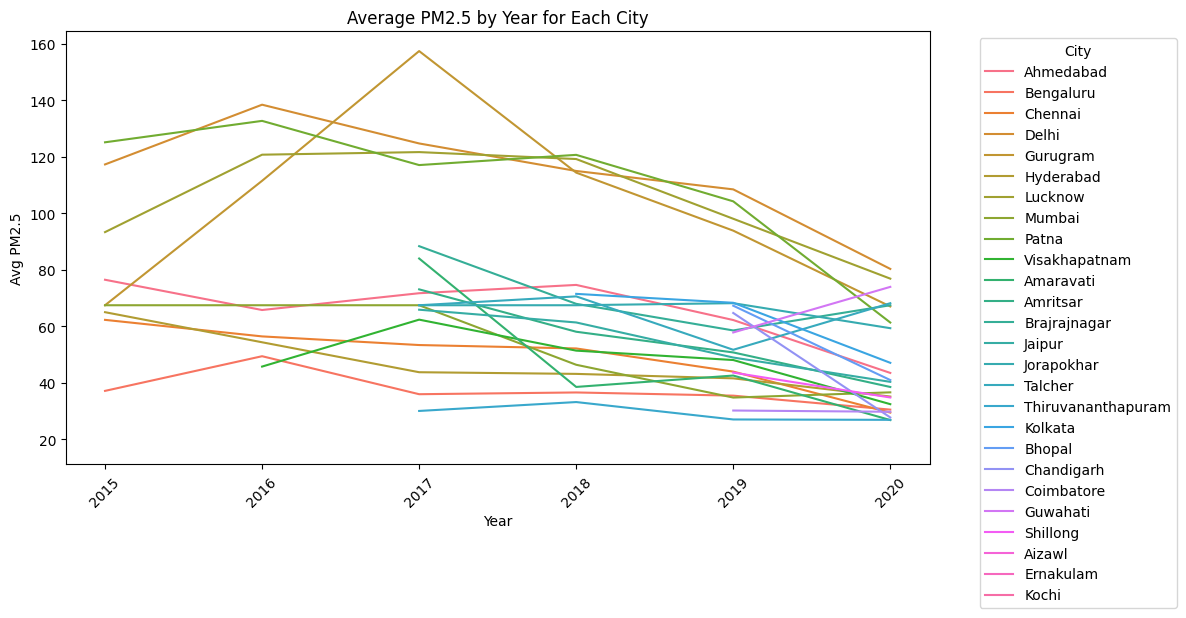

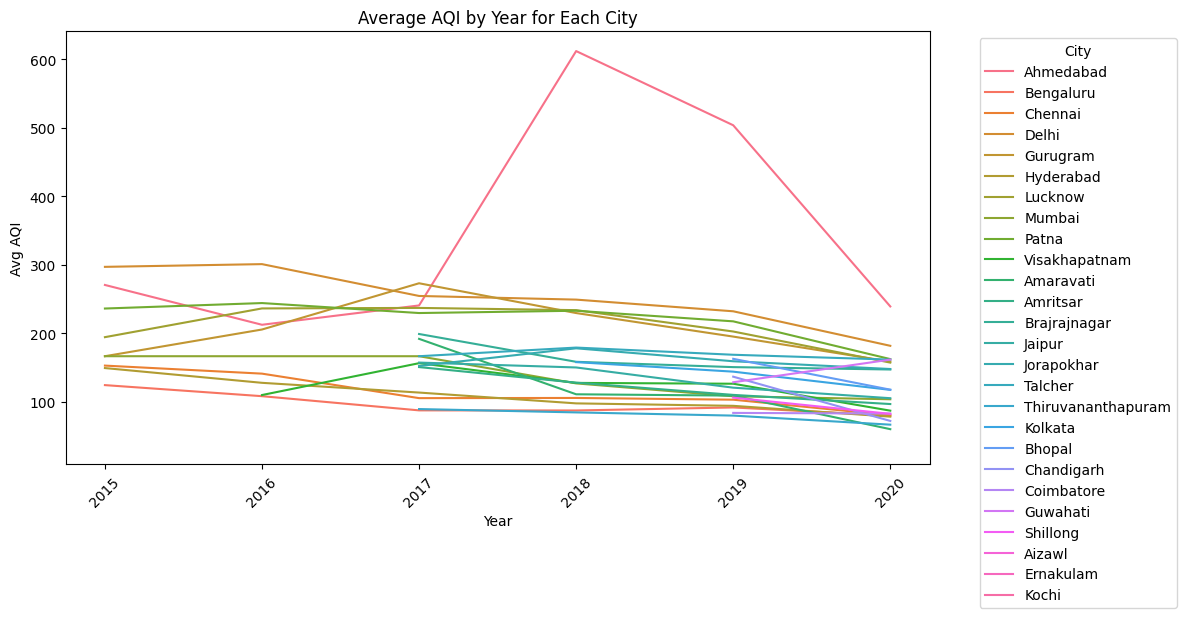

In [71]:
visualize_yearly_trends(yearly_trends_df)


In [74]:
import pandas as pd
import glob2

# Use glob to find all matching files
# Assuming the files are directly within '/content/monthly_patterns.csv'
files = glob2.glob('/content/monthly_patterns.csv/*.csv')  # Changed to use glob2

In [85]:
import pandas as pd
import glob

# 1. Get a list of files matching the pattern
files = glob.glob('/content/pollution_hotspots.csv/part-00000-*.csv')  # Correct path and use glob

In [88]:
def visualize_pollution_hotspots(pollution_hotspots):
    """
    Visualize the top 3 most polluted cities by year.

    Args:
        pollution_hotspots (DataFrame): Pollution hotspots data (Pandas DataFrame)
    """
    # Create a grouped bar plot for top 3 polluted cities per year
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Year', y='Avg_PM2_5', hue='City', data=pollution_hotspots)
    plt.title('Top 3 Most Polluted Cities by Year')
    plt.xlabel('Year')
    plt.ylabel('Avg PM2.5')
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


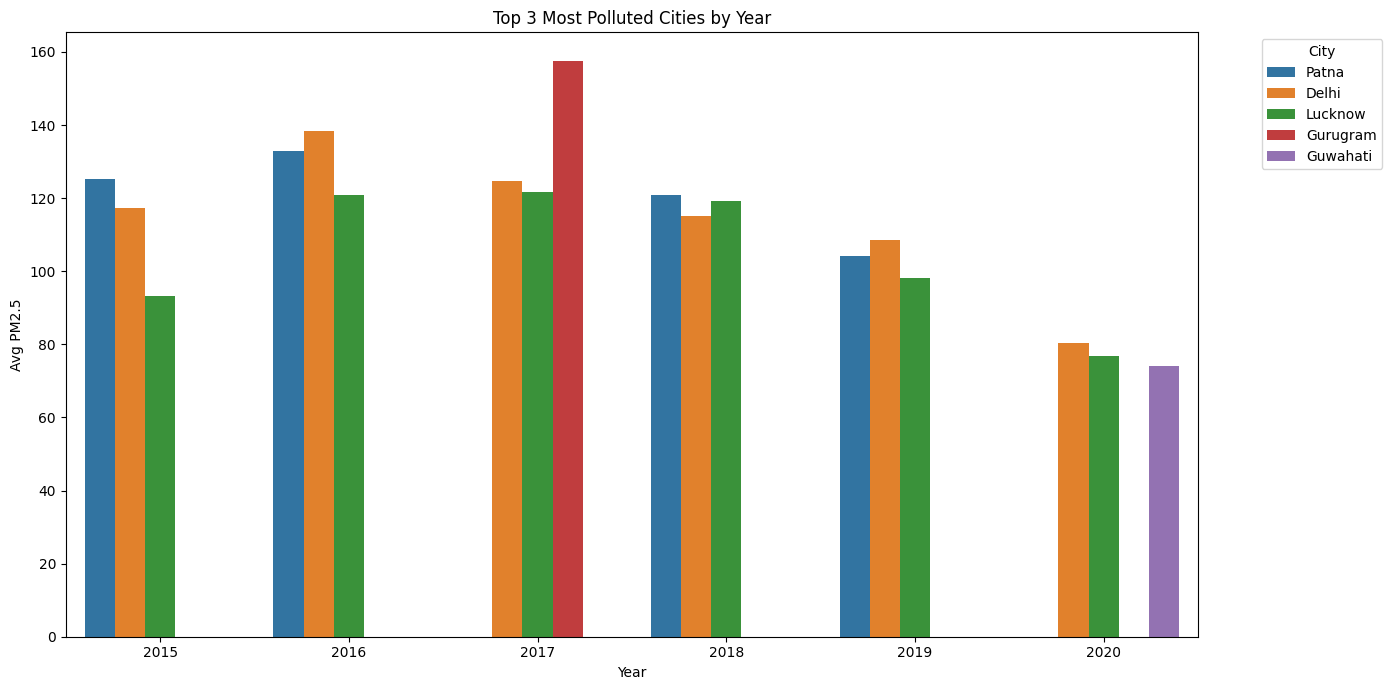

In [89]:
visualize_pollution_hotspots(pollution_hotspots_df)


In [90]:
def visualize_monthly_patterns(monthly_patterns):
    """
    Visualize the monthly pollution patterns.

    Args:
        monthly_patterns (DataFrame): Monthly pollution patterns (Pandas DataFrame)
    """
    # Line plot for monthly average PM2.5
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Month", y="Avg_PM2.5", data=monthly_patterns, marker='o', label="Avg PM2.5")
    sns.lineplot(x="Month", y="Avg_AQI", data=monthly_patterns, marker='o', label="Avg AQI")
    plt.title('Monthly Pollution Patterns (Avg PM2.5 and AQI)')
    plt.xlabel('Month')
    plt.ylabel('Values')
    plt.xticks(range(1, 13))  # Months are 1 through 12
    plt.legend(title="Metrics")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


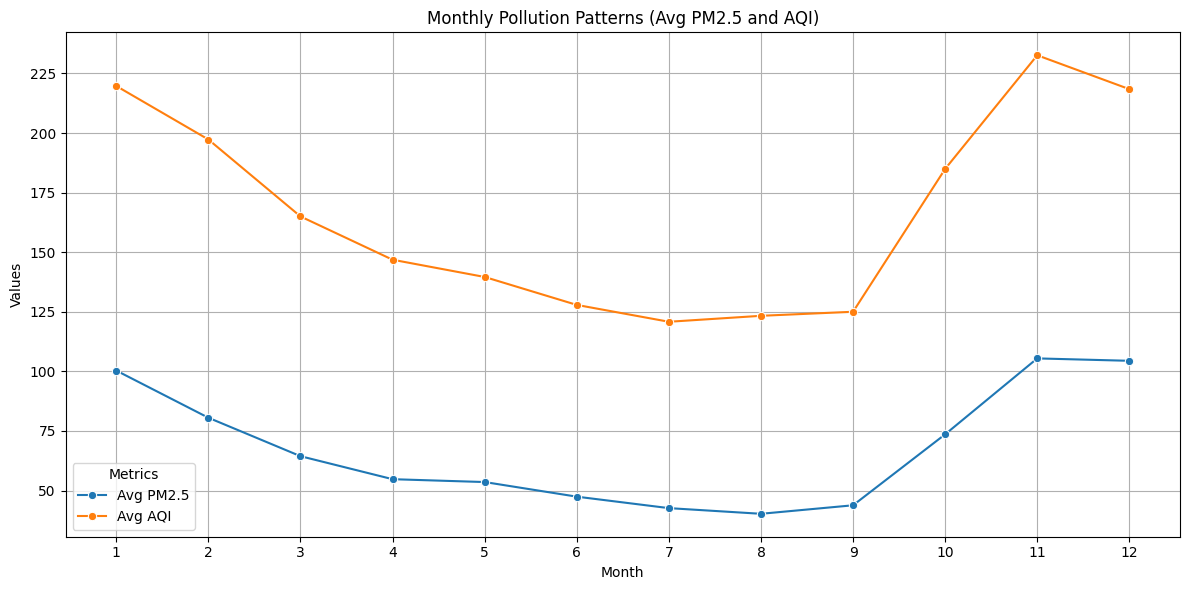

In [91]:
visualize_monthly_patterns(monthly_patterns_df)


<ipython-input-102-2bcf4bc8eb8e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AQI_Bucket", y="count", data=aqi_distribution_pd, palette="viridis")


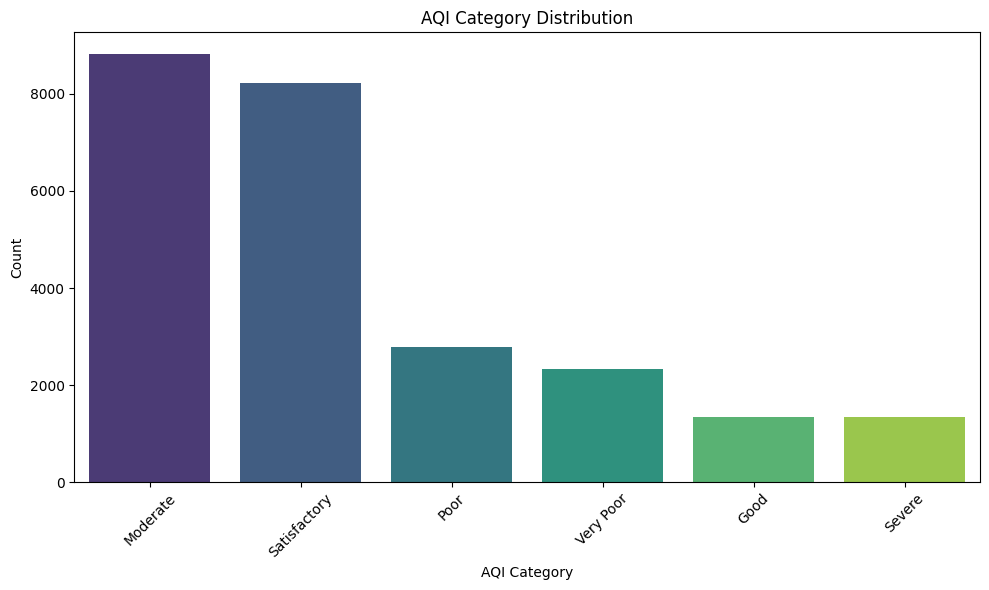

In [102]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you want to read all the files into one Pandas DataFrame
files = glob.glob('/content/aqi_distribution.csv/part-00000-*.csv')
aqi_distribution_pd = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

def visualize_aqi_distribution(aqi_distribution_pd):  # Changed the argument to aqi_distribution_pd
    """
    Visualize the AQI category distribution using a bar plot.

    Args:
        aqi_distribution_pd (DataFrame): Pandas DataFrame containing the AQI distribution.
    """

    # Bar plot for AQI category distribution
    plt.figure(figsize=(10, 6))
    # Using the correct DataFrame name 'aqi_distribution_pd' here:
    sns.barplot(x="AQI_Bucket", y="count", data=aqi_distribution_pd, palette="viridis")
    plt.title("AQI Category Distribution")
    plt.xlabel("AQI Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Now you can visualize the data
visualize_aqi_distribution(aqi_distribution_pd)  # Pass the correct DataFrame to the function

<ipython-input-104-b96ac73fc8a9>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Avg_PM2.5', data=monthly_patterns_df, palette='Blues_d')


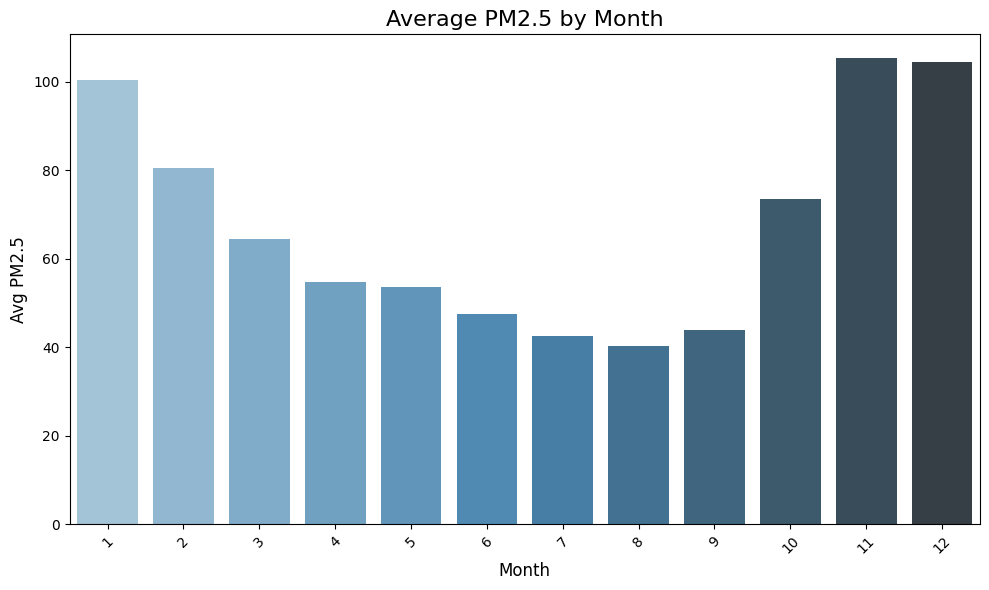

<ipython-input-104-b96ac73fc8a9>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Avg_AQI', data=monthly_patterns_df, palette='Oranges_d')


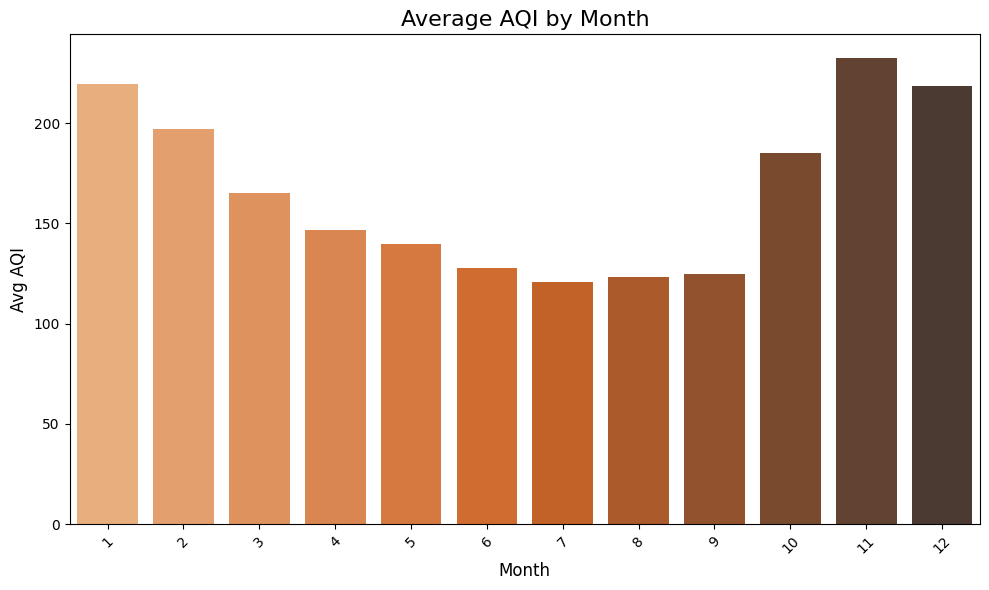

In [104]:
def visualize_monthly_patterns(monthly_patterns_df):
    """
    Visualize the monthly pollution patterns (PM2.5 and AQI).

    Args:
        monthly_patterns_df (DataFrame): Pandas DataFrame with monthly pollution patterns.
    """
    # Plotting Average PM2.5 by Month
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Month', y='Avg_PM2.5', data=monthly_patterns_df, palette='Blues_d')
    plt.title('Average PM2.5 by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Avg PM2.5', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting Average AQI by Month
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Month', y='Avg_AQI', data=monthly_patterns_df, palette='Oranges_d')
    plt.title('Average AQI by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Avg AQI', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Load the monthly patterns data from CSV
files = glob2.glob('/content/monthly_patterns.csv/part-00000-*.csv')
monthly_patterns_df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Visualize monthly patterns
visualize_monthly_patterns(monthly_patterns_df)


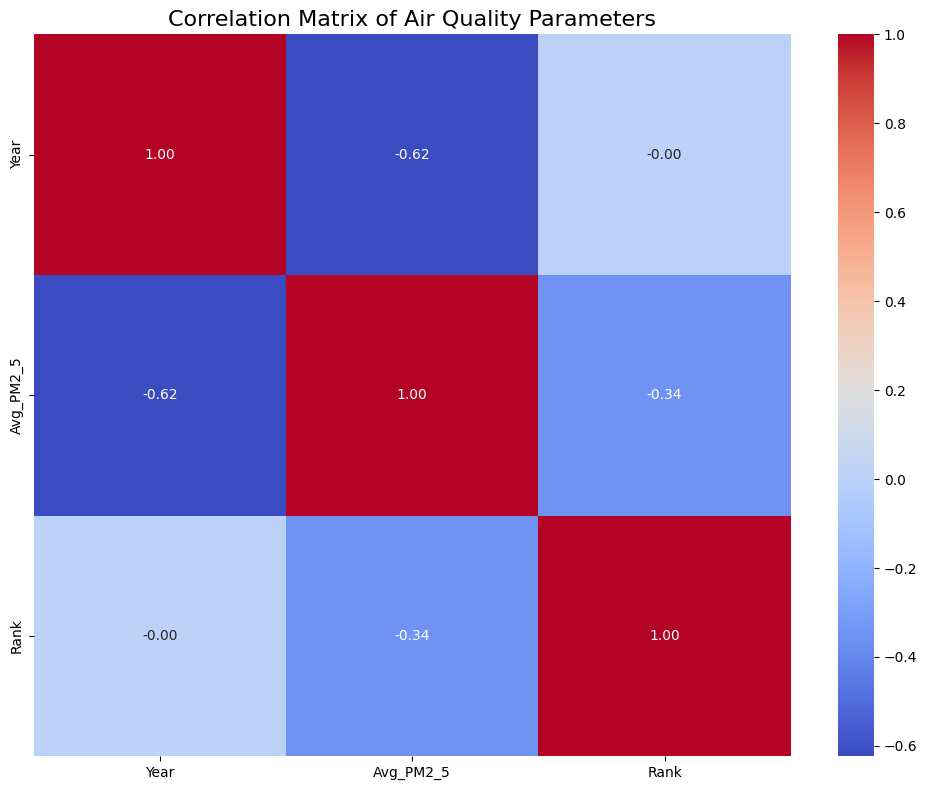

In [109]:
def plot_correlation_matrix(df):
    """
    Plot a correlation matrix for air quality parameters.

    Args:
        df (DataFrame): Pandas DataFrame with air quality data.
    """
    # Select only numeric columns for correlation calculation
    numeric_df = df.select_dtypes(include=['number'])
    correlation_matrix = numeric_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Air Quality Parameters', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(df) # Changed air_quality_df to df

In [110]:
import folium

def map_pollution_hotspots(df):
    """
    Create a map of pollution hotspots over India.

    Args:
        df (DataFrame): Pandas DataFrame with 'City', 'Latitude', 'Longitude', and 'Avg_PM2.5'.
    """
    # Set map center to coordinates roughly in the center of India
    map_center = [22.5937, 78.9629]  # Latitude and Longitude for India
    pollution_map = folium.Map(location=map_center, zoom_start=5)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=row['Avg_PM2.5'] / 10,  # Scale radius to PM2.5 values
            color='red',
            fill=True,
            fill_opacity=0.7,
            tooltip=f"City: {row['City']}, PM2.5: {row['Avg_PM2.5']}"
        ).add_to(pollution_map)

    return pollution_map

In [111]:
import pandas as pd
import folium

# Assuming your DataFrame is named 'df' and has columns:
# 'City', 'Latitude', 'Longitude', 'Avg_PM2.5'

# 1. Sample data (replace with your actual data)
data = {
    'City': ['Delhi', 'Mumbai', 'Bangalore', 'Chennai', 'Kolkata'],
    'Latitude': [28.7041, 19.0760, 12.9716, 13.0827, 22.5726],
    'Longitude': [77.1025, 72.8777, 77.5946, 80.2707, 88.3639],
    'Avg_PM2.5': [150, 90, 60, 75, 120]  # Replace with your actual PM2.5 values
}
df = pd.DataFrame(data)

# 2. Function to create the map (from your original code)
def map_pollution_hotspots(df):
    map_center = [22.5937, 78.9629]  # Latitude and Longitude for India
    pollution_map = folium.Map(location=map_center, zoom_start=5)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=row['Avg_PM2.5'] / 10,
            color='red',
            fill=True,
            fill_opacity=0.7,
            tooltip=f"City: {row['City']}, PM2.5: {row['Avg_PM2.5']}"
        ).add_to(pollution_map)

    return pollution_map

# 3. Create and save the map
pollution_map = map_pollution_hotspots(df)
pollution_map.save("pollution_map_india.html")  # Save as HTML file